In [21]:
#Imports
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xarray as xr
import folium
import numpy as np
import pandas as pd
import datetime as dt

from eodag import EODataAccessGateway
from eodag import setup_logging

from rasterio.crs import CRS
from rioxarray.merge import merge_arrays

from dotenv import dotenv_values

# Setup Verbose Values:
# 0: no logging and no progress bar
# 1: no logging but progress bars displayed
# 2: log at the INFO level
# 3: log at the DEBUG level (even more information)

setup_logging(verbose=0)


# EODAG - deserialized post process

EODAG (Earth Observation Data Access Gateway) is a command line tool and a Python package for searching and downloading remotely sensed images while offering a unified API for data access regardless of the data provider.

EODAG gives you an easy way to access products from more than 10 providers, with more than 50 different product types (Sentinel 1, Sentinel 2, Sentinel 3, Landsat, etc.) that can be searched and downloaded.

In [2]:
#Get Secrets from .env File
secrets = dotenv_values('.env')

In [3]:
#Create Folders for saving Data, serializing and post processing.

# Path where the Data should be stored ('c:\\Users\\theUSER\\eodag-data')
root = '../eodag-data/'

workspace_download = os.path.join(root,'eodag_workspace_download')
workspace_serialize = os.path.join(root,'eodag_workspace_serialize_deserialize')
workspace_post_process = os.path.join(root,'eodag_workspace_post_process')
workspaces = [workspace_download, workspace_serialize, workspace_post_process]

for ws in workspaces:
    ws = os.path.abspath(ws)
    
    if not os.path.isdir(ws):
        os.mkdir(ws)
        print(f'Created Folder: {ws}')
    else:
        print(f'Folder already exists: {ws}')

Folder already exists: c:\Users\npikall\eodag-data\eodag_workspace_download
Folder already exists: c:\Users\npikall\eodag-data\eodag_workspace_serialize_deserialize
Folder already exists: c:\Users\npikall\eodag-data\eodag_workspace_post_process


## Step 1
### Configuration
In the configuration we pass the username and password from the Copernicus Dataspace Ecosystem (CDSE) to eodag. Also we define the path for the downloads.

In [4]:
# 1. Configure
#Create EODAG Object and set preferred Provider
dag = EODataAccessGateway()
dag.set_preferred_provider("cop_dataspace") # Copernicus Data Space Ecosystem

dag.update_providers_config(f"""
    cop_dataspace:
        download:
            outputs_prefix: {os.path.abspath(workspace_download)}
        auth:
            credentials:
                username: {secrets['USER_KEY']}
                password: {secrets['USER_SECRET']}
""")


## Step 2
### Deserialize
Since the search is already done (see Notebook `eodag_search`) and the search result has been serialized, we are going to deserialize the search result and register it. If it is only deserialized it won't be able to download the data.

In [5]:
# Deserialize the Search Results
output_file = os.path.join(workspace_serialize, "search_results.geojson")
deserialized_search_results = dag.deserialize_and_register(output_file)

print(f"Got {len(deserialized_search_results)} deserialized products.")

Got 4 deserialized products.


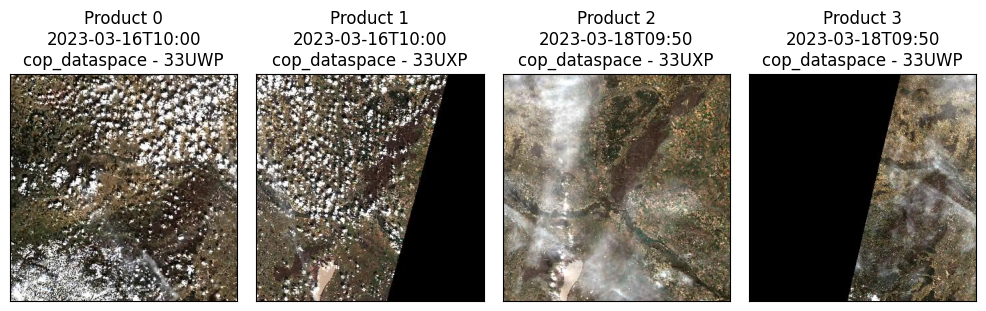

In [6]:
#Plot Quicklooks of Search Results
def plot_quicklooks(products):
    fig = plt.figure(figsize=(10,8))
    for i, product in enumerate(products[:12]):
        # This line takes care of downloading the quicklook
        quicklook_path = product.get_quicklook()
        
        date = product.properties['startTimeFromAscendingNode'][:16]
        provider = product.provider
        tile = product.properties['title'].split('_')[5].lstrip('T')
    
        # Plot the quicklook
        img = mpimg.imread(quicklook_path)
        ax = fig.add_subplot(3, 4, i+1)
        ax.set_title(f'Product {i}\n{date}\n{provider} - {tile}')
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                       labelleft=False, labelbottom=False)
        plt.imshow(img)
    plt.tight_layout()
    
plot_quicklooks(deserialized_search_results)

## Step 3
### Download 
Now either a single product or multiple products from the search will be downloaded. If the product has already been downloaded it will not load it again, if it is saved in the right workingspace.

In [7]:
# Download Single Product
product = deserialized_search_results[2]
path = dag.download(product)

# Download multiple Products
products = deserialized_search_results[1:3]
paths = dag.download_all(products)


In [8]:
# Set Boundingbox for Area inside the Tile.
latmin, latmax = 48.1, 48.35
lonmin, lonmax = 16.1, 16.6
extent = {'lonmin': lonmin, 'latmin': latmin, 'lonmax': lonmax, 'latmax': latmax}

# Folium Map
fmap = folium.Map(location=(np.array([latmin, latmax]).mean(), np.array([lonmin, lonmax]).mean()), zoom_start=9)
folium.Rectangle(bounds=[[latmin, lonmin],[latmax, lonmax]], color="red").add_to(fmap)
folium.GeoJson(
    data=deserialized_search_results[:],  # SearchResult has a __geo_interface__ interface used by folium to get its GeoJSON representation, single results dont work (this [2:3] instead of [2])
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)
fmap

In [9]:
# Setting common Parameters for all further image processing
common_params = dict(
    crs=CRS.from_epsg(4326),               # the downloaded images are in 4326, don't reproject them
    resolution=0.0006,                     # but lower their resolution (0.0006 should be 60m in 100km)
    extent=(lonmin,latmin,lonmax,latmax)   # and zoom over/crop the area of interest
)

# Define basic Functions for future operations
def normalized_difference(a, b):
    return (a - b*1.)/(a + b)

def normalize(a):
    return (a - a.min())/(a.max() - a.min())
    

## Step 4 
### Post Process

#### Example: Simple NDVI Image (as shown by eodag documentation)

In [10]:
# Load Bands 4 and 8 into memory
RED = product.get_data(band="B04", **common_params)
NIR = product.get_data(band="B08", **common_params)

NDVI = normalized_difference(NIR, RED)

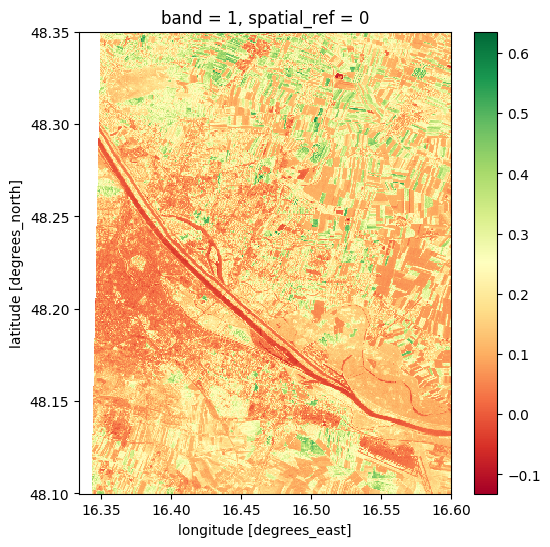

In [11]:
# Plot the NDVI Image
NDVI.plot(cmap="RdYlGn", center=False, size=6, aspect='equal')

#### Loading Bands as Dataset

The Level-2A processing includes a Scene Classification and an Atmospheric Correction applied to Top-Of-Atmosphere (TOA) Level-1C orthoimage products. Level-2A main output is an orthoimage atmospherically corrected, Surface Reflectance product.

Please be aware that "Surface Reflectance (SR)" is a new term that has been introduced to replace the former one: "Bottom of Atmosphere (BOA) reflectance."

Additional outputs are an Aerosol Optical Thickness (AOT) map, a Water Vapour (WV) map and a Scene Classification (SCL) map together with Quality Indicators (QI) for cloud and snow probabilities at 60 m resolution. Level-2A output image products are resampled and generated with an equal spatial resolution for all bands (10 m, 20 m or 60 m). Standard distributed products contain the envelope of all resolutions in three distinct folders:


- 10 m: containing spectral bands 2, 3, 4 , 8, a True Colour Image (TCI) and an AOT and WVP maps resampled from 20 m.

- 20 m: containing spectral bands 1 - 7, the bands 8A, 11 and 12, a True Colour Image (TCI), a Scene Classification (SCL) map and an AOT and WVP map. The band B8 is omitted as B8A provides more precise spectral information.

- 60 m: containing all components of the 20 m product resampled to 60 m and additionally the bands 1 and 9, a True Colour Image (TCI), a Scene Classification (SCL) map and an AOT and WVP map. The cirrus band 10 is omitted, as it does not contain surface information.

In [12]:
# Get a list of all available Bands (assets)
def get_assets(root:str, res=60):
    jp2_files = [file for dirs in os.walk(root, topdown=True)
                     for file in dirs[2] if file.endswith(f"_{res}m.jp2")]
    assets = [file.split('_')[2] for file in jp2_files if file.startswith('T')]
    return assets
    
    
assets = get_assets(path, res=10)
assets

['AOT', 'B02', 'B03', 'B04', 'B08', 'TCI', 'WVP']

In [19]:
# Functions for loading data into datasets.

def load_single_product(product, bands:list):
    loaded_data = {}

    for band in bands:
        data = product.get_data(band=band, **common_params)
        data = data.squeeze()

        time_str = product.properties['startTimeFromAscendingNode']
        date = dt.datetime.strptime(time_str,'%Y-%m-%dT%H:%M:%S.%f%z')

        data = data.expand_dims(dim={'time':[date.date()]})
        data.name = band
        loaded_data[band] = data
    ds = xr.Dataset(loaded_data)
    return ds

def load_multiple_timestamps(products, bands:list):
    loaded_data = {}
    # Combine multiple Dataarrays into one Dataset
    for band in bands:
        single_band_ts = []
        # Load one Band of each product and concat them into an xarray Dataarray
        for prod in products: 
            data = prod.get_data(band=band, **common_params)
            data = data.squeeze()

            time_str = prod.properties['startTimeFromAscendingNode'][:-1] #Remove Timezone info
            date = pd.to_datetime([time_str])

            data = data.expand_dims(time=date)
            data.name = band
            single_band_ts.append(data)
            
        ts =  xr.concat(single_band_ts, dim='time')
        loaded_data[band] = ts   

    ds = xr.Dataset(loaded_data)
    return ds

In [14]:
# Loading multiple Bands into a dataset
ds1 = load_single_product(product=product, bands=['B04', 'B03', 'B02', 'B08', 'TCI'])

In [22]:
# Loading multiple Bands into a dataset with multiple Timestamps
ds = load_multiple_timestamps(products=products, bands=['B04', 'B03', 'B02', 'B08', 'TCI'])

In [23]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:      (time: 2, x: 833, y: 416, band: 3)
Coordinates:
  * time         (time) datetime64[ns] 16B 2023-03-16T10:00:29.024000 2023-03...
  * x            (x) float64 7kB 16.33 16.33 16.34 16.34 ... 16.6 16.6 16.6 16.6
  * y            (y) float64 3kB 48.35 48.35 48.35 48.35 ... 48.1 48.1 48.1 48.1
  * band         (band) int32 12B 1 2 3
    spatial_ref  int32 4B 0
Data variables:
    B04          (time, y, x) uint16 1MB 0 0 0 0 0 ... 3150 3100 3094 3046 3004
    B03          (time, y, x) uint16 1MB 0 0 0 0 0 ... 2930 2898 2868 2880 2806
    B02          (time, y, x) uint16 1MB 0 0 0 0 0 ... 2786 2736 2754 2748 2714
    B08          (time, y, x) uint16 1MB 0 0 0 0 0 ... 3764 3708 3718 3734 3706
    TCI          (time, band, y, x) uint8 2MB 0 0 0 0 0 ... 181 176 178 176 173

In [ ]:
# Plotting the True Color Image (TCI)
ds['TCI'].loc[ds['TCI'].time[1]].plot.imshow()

In [ ]:
# Calculating the NDVI and adding it to the dataset
ndvi = normalized_difference(ds['B08'], ds['B04'])
ds['NDVI'] = ndvi
ds

In [25]:
# Selecting a single timestamp from the dataset
single_img = ds.sel(time=dt.date(2023, 3, 16), method='nearest')
single_img

<xarray.Dataset> Size: 4MB
Dimensions:      (x: 833, y: 416, band: 3)
Coordinates:
    time         datetime64[ns] 8B 2023-03-16T10:00:29.024000
  * x            (x) float64 7kB 16.33 16.33 16.34 16.34 ... 16.6 16.6 16.6 16.6
  * y            (y) float64 3kB 48.35 48.35 48.35 48.35 ... 48.1 48.1 48.1 48.1
  * band         (band) int32 12B 1 2 3
    spatial_ref  int32 4B 0
Data variables:
    B04          (y, x) uint16 693kB 0 0 0 0 0 0 ... 3374 3172 3094 2800 2514
    B03          (y, x) uint16 693kB 0 0 0 0 0 0 ... 2874 2698 2638 2406 2178
    B02          (y, x) uint16 693kB 0 0 0 0 0 0 ... 2424 2300 2240 2078 1879
    B08          (y, x) uint16 693kB 0 0 0 0 0 0 ... 4068 3842 3798 3666 3646
    TCI          (band, y, x) uint8 1MB 0 0 0 0 0 0 0 ... 147 145 133 126 110 90

#### Merging of Arrays

In this example two geographicaly overlapping images are merged, and the NDVI is calculated. Note that only Dataarrays are merged but not Datasets.

In [ ]:
# Load Data of Bands 4 and 8. The Images are from the same time, but different tiles.
RED_1 = deserialized_search_results[2].get_data(band="B04", **common_params)
RED_2 = deserialized_search_results[3].get_data(band="B04", **common_params)

NIR_1 = deserialized_search_results[2].get_data(band="B08", **common_params)
NIR_2 = deserialized_search_results[3].get_data(band="B08", **common_params)

In [ ]:
# Using merge_arrays returns the geospatially merged data.
merged_red = merge_arrays([RED_1, RED_2], method='max') # methods = ['first', 'last', 'min', 'max', 'sum', 'count']
merged_nir = merge_arrays([NIR_1, NIR_2], method='max')

merged_ndvi = normalized_difference(merged_nir, merged_red)

In [ ]:
merged_ndvi.plot(cmap='RdYlGn', center=False, size=6, aspect='auto')

## Saving xarrays to netCDF Files

NetCDF (Network Common Data Form) is a set of software libraries and machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. It is also a community standard for sharing scientific data.

In [ ]:
# Create Folder for NetCDF Files

# nc_path = os.path.join(workspace_post_process, 'eodag_netCDF')

# if not os.path.isdir(nc_path):
#     os.mkdir(nc_path)
#     print(f'Created Folder: {os.path.abspath(nc_path)}')
# else:
#     print(f'Folder already exists: {os.path.abspath(nc_path)}')

In [ ]:
# Save Xarray as NetCDF
# file_path = os.path.join(nc_path, 'dataset.nc')

# if not os.path.isfile(file_path):
#     # If File not existing, then write the File
#     ds.to_netcdf(file_path, mode='w')
# else:
#     # If File is existing, then delete and write again.
#     os.remove(file_path)
#     ds.to_netcdf(file_path, mode='w')


# OR Append netCDF File with:
# ds.to_netcdf(file_path, mode='a')